## Perceptual Loss

En este notebook tratamos de crear el "perceptual loss" (también llamado "content loss" o "feature loss"), como se definió en el artículo de [Gatys](https://arxiv.org/abs/1508.06576) de Style-Transfer. Después lo probaremos con la aplicación más tonta de machine learning del mundo: recrear una imagen dada.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai
import fastai.basics as fai
import fastai.vision as fv
from fastai.callbacks import hook_outputs, hook_output
#from fastai.utils.mem import *
from pathlib import Path
from shutil import copyfile
import random
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torchvision.utils as utils
import torchvision.models
from torch.utils.data import DataLoader, Dataset
import PIL
from tqdm import tqdm_notebook as tqdm
import gc
import matplotlib.pyplot as plt
import numpy as np
import gc

In [3]:
vgg = torchvision.models.vgg16_bn(pretrained=True)

In [4]:
vgg.eval()
fai.requires_grad(vgg, False)

In [5]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

No nos interesan para nada la parte de "classifier", así que nos quedamos únicamente con las "features"

In [6]:
vgg = vgg.features

In [7]:
gc.collect()

110

Ahora, queremos usar las capas justo antes a que se pierde información, o sea, justo antes de las max-pools. Podemos ver cuáles capas son así:

In [8]:
good_blocks = [i-1 for i,o in enumerate(vgg.children()) if isinstance(o,nn.MaxPool2d)]

In [9]:
good_blocks

[5, 12, 22, 32, 42]

Listo! Ahora podemos definir el PerceptualLoss, usando "hooks" de pytorch. A los modelos de pytorch se les pueden definir unos "ganchos" (hook = gancho en inglés) que son simplemente funciones que se corren cuando pasas algo por el modelo.

fastai trae la función "hook_outputs", que simplemente le pone hooks a una lista de modelos de pytorch, y eso guarda el resultado. La usaremos, pero no es difícil de programar.

In [10]:
class PerceptualLoss(nn.Module):
    def __init__(self, model, layer_ids, weights):
        super().__init__()
        self.model = model
        self.important_layers = [self.model[i] for i in layer_ids]
        self.hooks = hook_outputs(self.important_layers, detach=False)
        self.weights = weights

    def extract_features(self, x, clone=False):
        self.model(x)
        features = list(self.hooks.stored)
        
        if clone:
            features = [f.clone() for f in features]
        
        return features
    
    def forward(self, input, target):
        criterion = F.l1_loss
        
        input_features = self.extract_features(input)
        target_features = self.extract_features(target, clone=True)
        
        self.feat_losses = [criterion(input,target)]
        self.feat_losses += [criterion(in_f, targ_f)*w for in_f, targ_f, w in zip(input_features, target_features, self.weights)]
        
        return sum(self.feat_losses)
    
    def __del__(self): 
        self.hooks.remove() # necesario para que deje de guardar las cosas

Vamos a usar las layers de la 2 en adelante nada más. Las primeras se parecen demasiado a la imagen y no nos dicen tanto de su feature loss.

Podemos jugar con los pesos, aunque he visto que no altera mucho el resultado.

In [11]:
perceptual_loss = PerceptualLoss(vgg, layer_ids=good_blocks[2:], weights=[5,15,2])

# Aplicación más tonta del mundo: recrear una imagen.
Vamos a empezar con una imagen de ruido al azar y la modificaremos poco a poco para recrear una imagen dada.

In [39]:
img = torch.rand((1,3,224,224), requires_grad=True)

In [40]:
def show_tensor_as_image(tensor, ncols=5, figsize=10, title = ""):
    plt.figure(figsize=(figsize,figsize))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(utils.make_grid(tensor.detach().cpu()[:ncols*ncols], nrow=ncols, padding=2, normalize=True).cpu(),(1,2,0)))

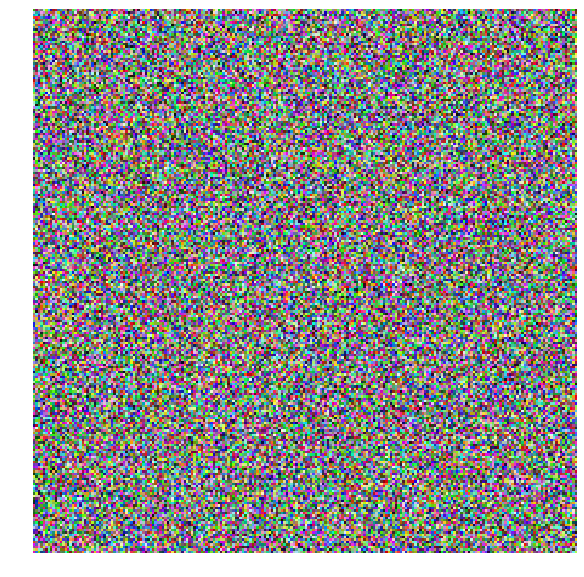

In [41]:
show_tensor_as_image(img)

Ahora iremos modificando poco a poco la imagen para que se parezca a esta:

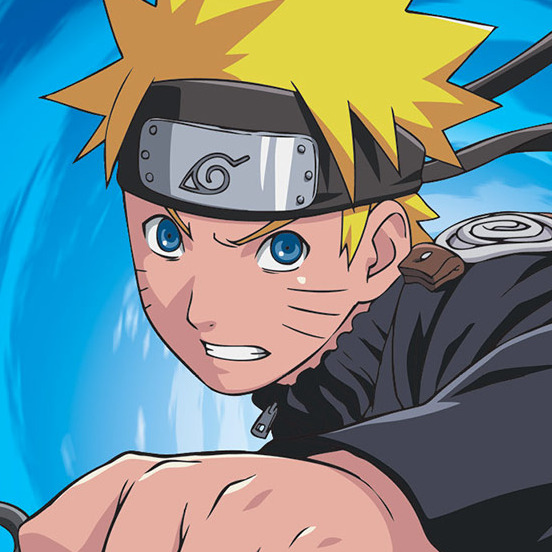

In [42]:
target = fv.open_image("naruto.jpg");
target

In [44]:
target = target.resize(224)

In [45]:
target.shape

torch.Size([3, 552, 552])

In [46]:
target = target.data

In [47]:
target.shape

torch.Size([3, 224, 224])

In [48]:
img.shape

torch.Size([1, 3, 224, 224])

In [49]:
target = target.unsqueeze(0)

In [59]:
def train(num_epochs, lr=1e-3):
    optim = torch.optim.Adam([img], lr=lr)
    with tqdm(range(num_epochs)) as pbar:
        for epoch in pbar:
            optim.zero_grad()
            loss = perceptual_loss(img,target)
            loss.backward()
            optim.step()
            pbar.set_postfix(loss=loss.item())
    

In [56]:
train(50,1e-1)

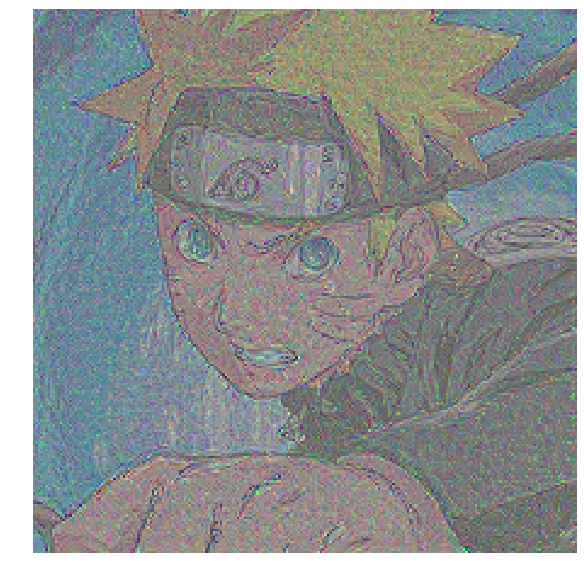

In [57]:
show_tensor_as_image(img)

In [60]:
train(50,1e-2)

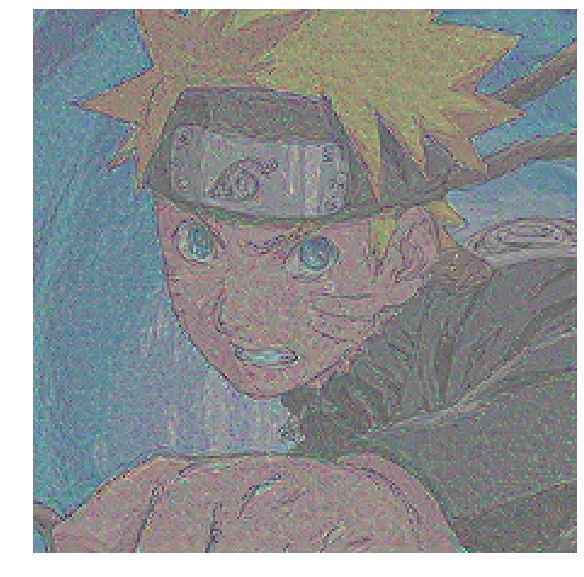

In [61]:
show_tensor_as_image(img)

¿Qué pasa si en vez de empezar con un dibujo aleatorio empezamos con un dibujo de otra cosa?

In [63]:
img = fv.open_image("luffy.jpg").resize(224).data.unsqueeze(0).detach().cuda()

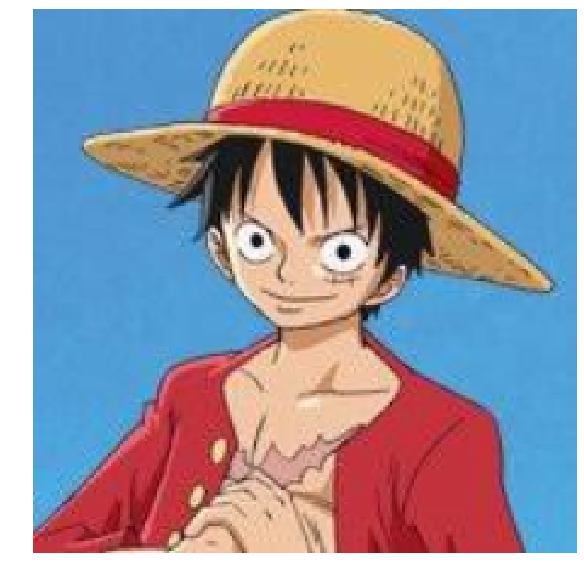

In [64]:
show_tensor_as_image(img)

In [65]:
perceptual_loss = perceptual_loss.cuda()

In [67]:
target=target.cuda()

In [70]:
img=img.requires_grad_(True)

In [73]:
train(50,1e-2)

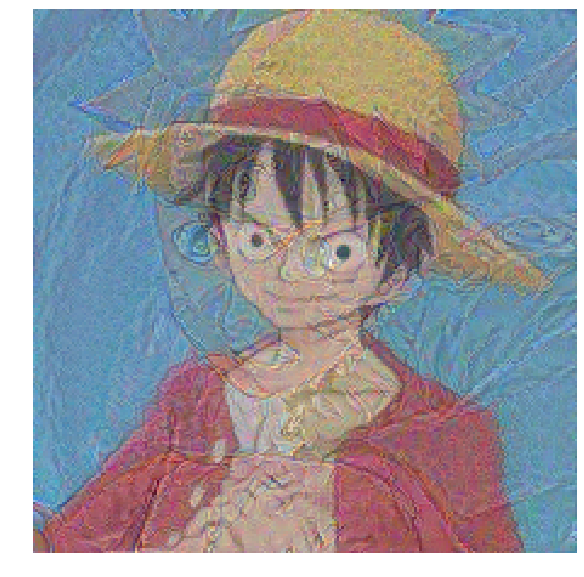

In [72]:
show_tensor_as_image(img)

In [ ]:
train(500,1e-2)

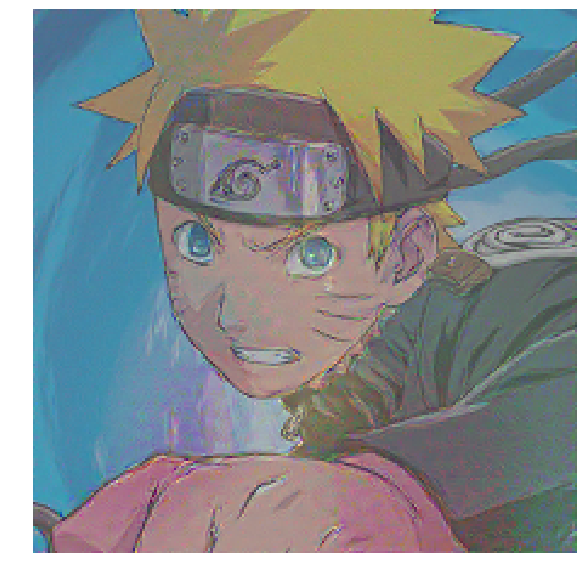

In [74]:
show_tensor_as_image(img)